# Assignment 3 by: YourFullName (YourStudentID)


## EDA

In [4]:
ls

A3code-Template.ipynb  A3code-Template_Part2.ipynb  ml-1m/  ml-1m.zip


In [5]:
cd ./ml-1m

/home/rick/Desktop/Nhat/ml-1m


In [104]:
# pip install modin[dask] dask

In [105]:
# !pip install modin==0.12.1 pandas==1.3.3

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [106]:
# !pip install bottleneck==1.3.6

In [107]:
# !pip install pandas numpy scikit-learn matplotlib scipy seaborn lightfm

In [108]:
# !pip install lightfm

## Data Loading

In [7]:
df_user = pd.read_csv('users.dat', sep='::', engine='python', names=['UserID','Gender','Age','Occupation',"Zip-code"])
df_movies = pd.read_csv('movies.dat', sep='::', engine='python', names=["MovieID","Title","Genres"], encoding='latin-1')
df_ratings = pd.read_csv('ratings.dat', sep='::', engine='python', names=["UserID","MovieID","Rating","Timestamp"])


FileNotFoundError: [Errno 2] No such file or directory: 'users.dat'

In [ ]:
df_user.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [10]:
df_movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [11]:
df_ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [12]:
from sklearn.preprocessing import MultiLabelBinarizer

def clean_recommender_data(df_user, df_ratings, df_movies):
    # Merge dataframes based on 'UserID' and 'MovieID'
    df_merged = pd.merge(df_user, df_ratings, on='UserID')
    df_merged = pd.merge(df_merged, df_movies, on='MovieID')
    
    # Drop rows with missing values
    df_clean = df_merged.dropna()
    
    # Remove duplicate rows
    df_clean = df_clean.drop_duplicates()
    
    # Ensure the correct data types
    df_clean['UserID'] = df_clean['UserID'].astype(int)
    df_clean['MovieID'] = df_clean['MovieID'].astype(int)
    df_clean['Rating'] = df_clean['Rating'].astype(float)
    
    # Strip trailing/leading whitespace from 'Gender' and 'Title' columns
    if 'Gender' in df_clean.columns:
        df_clean['Gender'] = df_clean['Gender'].str.strip()

    if 'Title' in df_clean.columns:
        df_clean['Title'] = df_clean['Title'].str.strip()
    
    # Check for ratings out of range and remove invalid ones
    df_clean = df_clean[(df_clean['Rating'] >= 1) & (df_clean['Rating'] <= 5)]
    
    # Split the Genres column into multiple genres
    df_clean['Genres'] = df_clean['Genres'].str.split('|')

    # Apply Multi-Hot Encoding (One-Hot Encoding) to the Genres column
    mlb = MultiLabelBinarizer()
    genre_encoded = mlb.fit_transform(df_clean['Genres'])

    # Create a DataFrame with the one-hot encoded genres and join with the original DataFrame
    df_genre_encoded = pd.DataFrame(genre_encoded, columns=mlb.classes_, index=df_clean.index)
    
    # Concatenate the encoded genres back to the original DataFrame
    df_clean = pd.concat([df_clean, df_genre_encoded], axis=1)
    
    # # Drop the original Genres column
    # df_clean.drop('Genres', axis=1, inplace=True)
    
    # Optional: Filter out users and movies with few interactions (for sparse data)
    user_counts = df_clean['UserID'].value_counts()
    movie_counts = df_clean['MovieID'].value_counts()

    # Keep users with at least 5 ratings and movies with at least 10 ratings
    df_clean = df_clean[df_clean['UserID'].isin(user_counts[user_counts >= 5].index)]
    df_clean = df_clean[df_clean['MovieID'].isin(movie_counts[movie_counts >= 10].index)]
    
    return df_clean

# Usage example:
# Assuming df_user, df_ratings, and df_movies are your input DataFrames
df_cleaned = clean_recommender_data(df_user, df_ratings, df_movies)

the groupby keys will be sorted anyway, although the 'sort=False' was passed. See the following issue for more details: https://github.com/modin-project/modin/issues/3571.


In [13]:
df_cleaned.head()

,UserID,Gender,Age,Occupation,Zip-code,MovieID,Rating,Timestamp,Title,Genres,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,F,1,10,48067,1193,5.0,978300760,One Flew Over the Cuckoo's Nest (1975),[Drama],...,0,0,0,0,0,0,0,0,0,0
1,1,F,1,10,48067,661,3.0,978302109,James and the Giant Peach (1996),"[Animation, Children's, Musical]",...,0,0,0,1,0,0,0,0,0,0
2,1,F,1,10,48067,914,3.0,978301968,My Fair Lady (1964),"[Musical, Romance]",...,0,0,0,1,0,1,0,0,0,0
3,1,F,1,10,48067,3408,4.0,978300275,Erin Brockovich (2000),[Drama],...,0,0,0,0,0,0,0,0,0,0
4,1,F,1,10,48067,2355,5.0,978824291,"Bug's Life, A (1998)","[Animation, Children's, Comedy]",...,0,0,0,0,0,0,0,0,0,0


In [14]:
df_cleaned['Title'].nunique()

3260

In [15]:
df_cleaned.to_csv('cleaned_data.csv', index=False)

Please refer to https://modin.readthedocs.io/en/stable/supported_apis/defaulting_to_pandas.html for explanation.


In [16]:
# !pip install fuzzywuzzy python-Levenshtein

# EDA



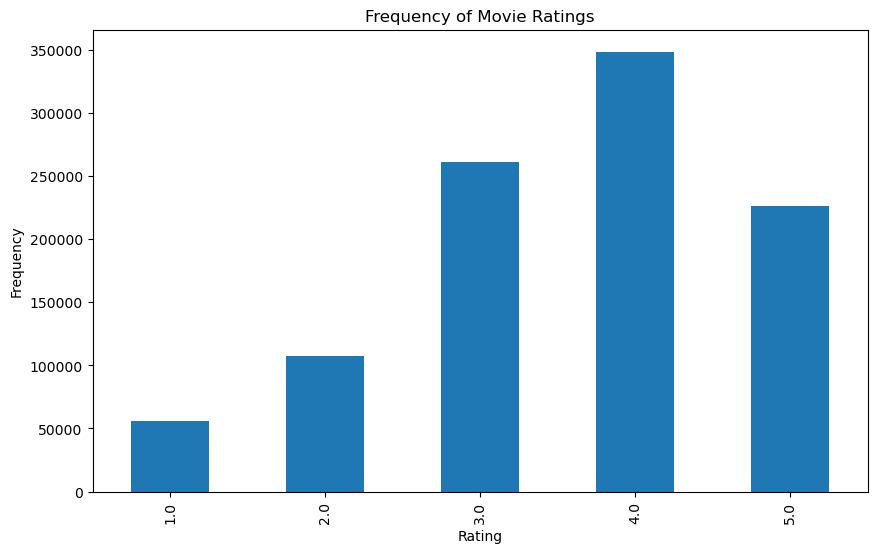

In [17]:
# Plot the frequency of movie ratings
plt.figure(figsize=(10, 6))
df_cleaned['Rating'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Frequency of Movie Ratings')
plt.show()

The bar chart displays the frequency distribution of movie ratings, where ratings range from 1.0 to 5.0.

	•	The highest number of ratings was for 4.0, with approximately 350,000 ratings.
	•	The second most common rating was 5.0, with around 275,000 ratings.
	•	Ratings of 3.0 and 2.0 show a moderate frequency, with about 200,000 and 100,000 ratings, respectively.
	•	The lowest frequency is for 1.0, with fewer than 50,000 ratings.

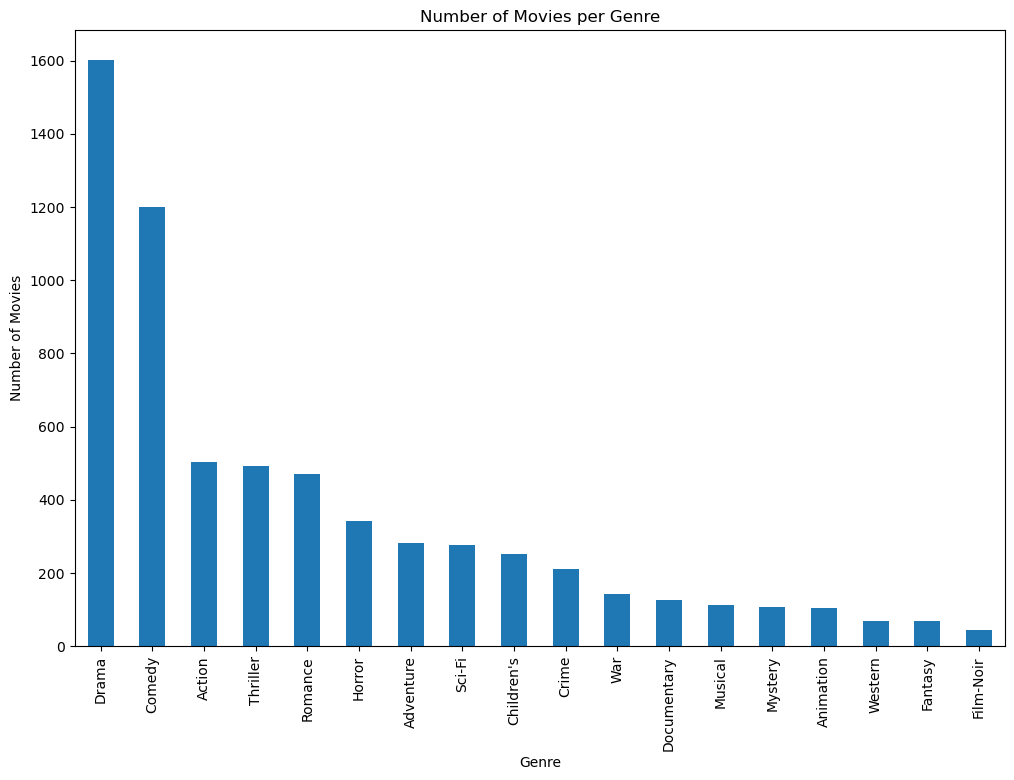

In [18]:
# Extract genres and count the occurrences
genre_counts = df_movies['Genres'].str.split('|').explode().value_counts()

# Plot the genre counts
plt.figure(figsize=(12, 8))
genre_counts.plot(kind='bar')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Number of Movies per Genre')
plt.show()

The bar chart illustrates the number of movies produced in each genre. The distribution shows that:

	•	Drama is the most common genre, with around 1600 movies, followed by Comedy with approximately 1200 movies.
	•	Action and Thriller genres both have around 600–700 movies each, making them the next most popular categories.
	•	Romance, Horror, and Adventure have a moderate representation, with 400–500 movies each.
	•	Genres like Children’s, Crime, and War feature less frequently but still have around 200–300 movies.
	•	The least represented genres include Musical, Mystery, Animation, Western, Fantasy, and Film-Noir, with less than 200 movies each.

This suggests that the movie industry has historically favored Drama and Comedy over more niche genres like Westerns and Film-Noir.

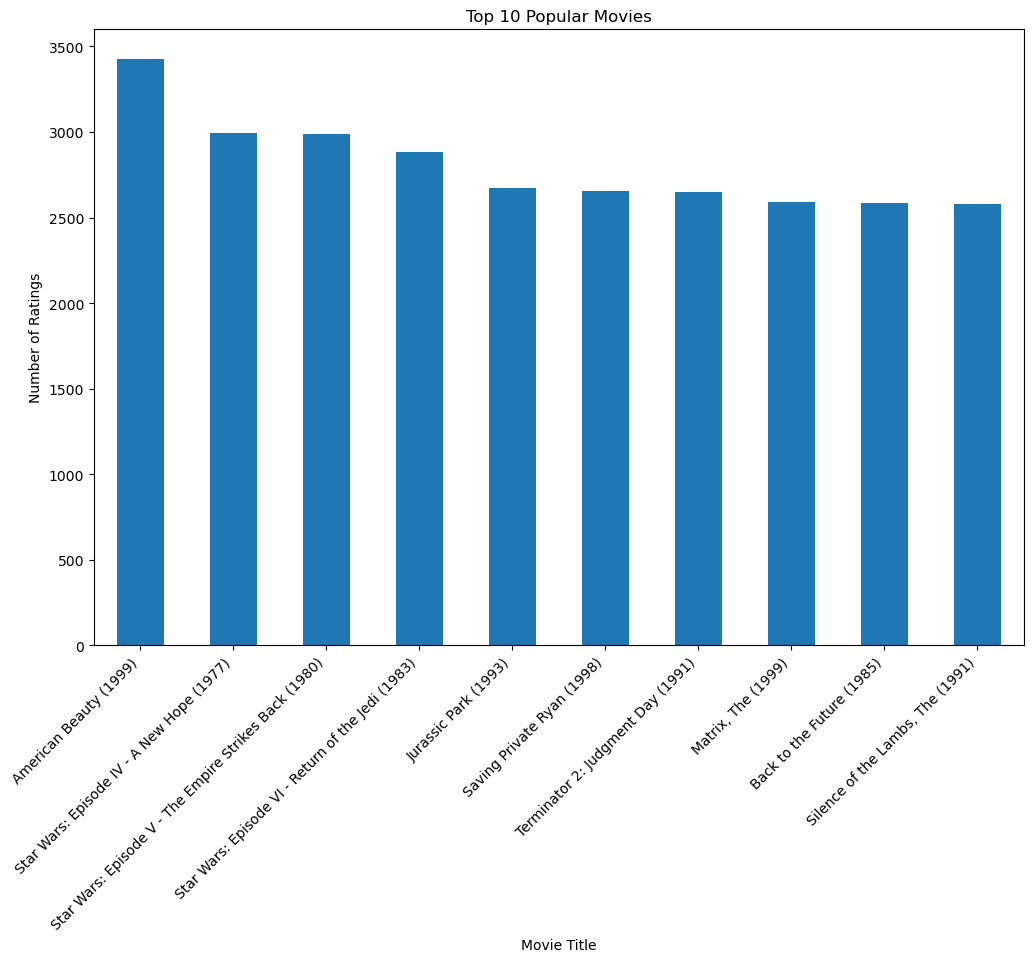

In [19]:
# Calculate the number of ratings for each movie
movie_ratings_count = df_cleaned['Title'].value_counts().head(10)

# Plot the top 10 popular movies
plt.figure(figsize=(12, 8))
movie_ratings_count.plot(kind='bar')
plt.xlabel('Movie Title')
plt.ylabel('Number of Ratings')
plt.title('Top 10 Popular Movies')
plt.xticks(rotation=45, ha='right')
plt.show()


The bar chart shows the top 10 most popular movies based on the number of ratings they have received:

	•	American Beauty (1999) is the most popular, with around 3,500 ratings.
	•	The Star Wars franchise dominates the list, with three entries: A New Hope (1977), The Empire Strikes Back (1980), and Return of the Jedi (1983), each with approximately 3,000 ratings.
	•	Other notable entries include Jurassic Park (1993), Saving Private Ryan (1998), and The Matrix (1999), all with around 2,800–3,000 ratings.
	•	Classic films like Back to the Future (1985) and The Silence of the Lambs (1991) round out the list, showing their continued popularity.

Overall, the chart suggests that both iconic science fiction and classic dramas from the late 20th century have garnered widespread viewership and ratings.

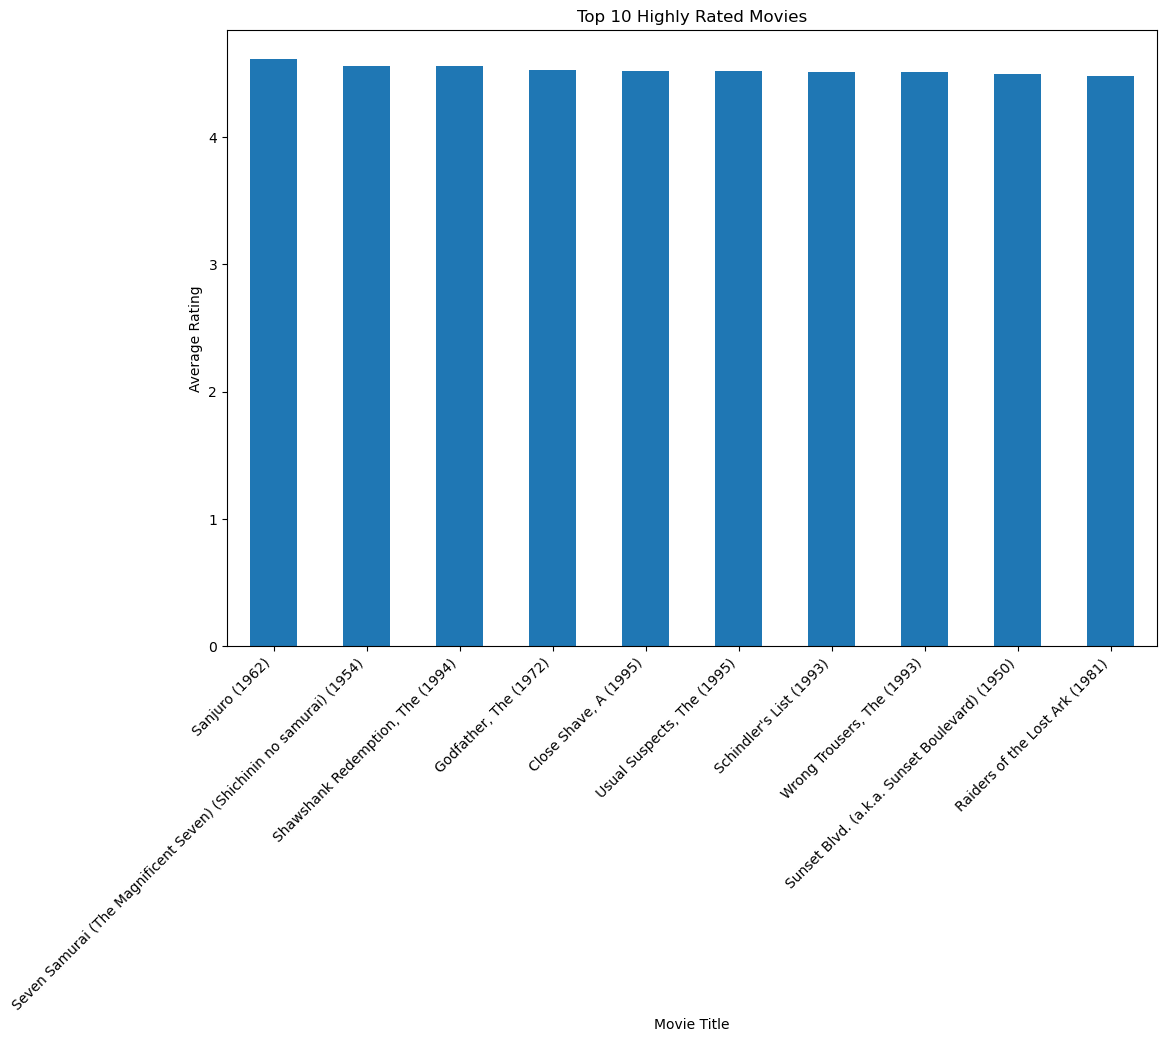

In [20]:
# Calculate the average rating for each movie
average_ratings = df_cleaned.groupby('Title')['Rating'].mean().sort_values(ascending=False).head(10)

# Plot the top 10 highly rated movies
plt.figure(figsize=(12, 8))
average_ratings.plot(kind='bar')
plt.xlabel('Movie Title')
plt.ylabel('Average Rating')
plt.title('Top 10 Highly Rated Movies')
plt.xticks(rotation=45, ha='right')
plt.show()

The bar chart represents the top 10 highest-rated movies, with each movie having an average rating of about 4.0 or higher:

	•	Sanjuro (1962), Shichinin no Samurai (1954), and The Shawshank Redemption (1994) are among the highest-rated movies, all consistently receiving average ratings above 4.0.
	•	Other classics such as The Godfather (1972), Schindler’s List (1993), and Sunset Blvd. (1950) also hold similar top ratings.
	•	A few animated and stop-motion films, like A Close Shave (1995) and The Wrong Trousers (1993), made it to the top of the chart, indicating broad appeal across genres.

In [21]:
# Install the wordcloud library
!pip install wordcloud

from wordcloud import WordCloud

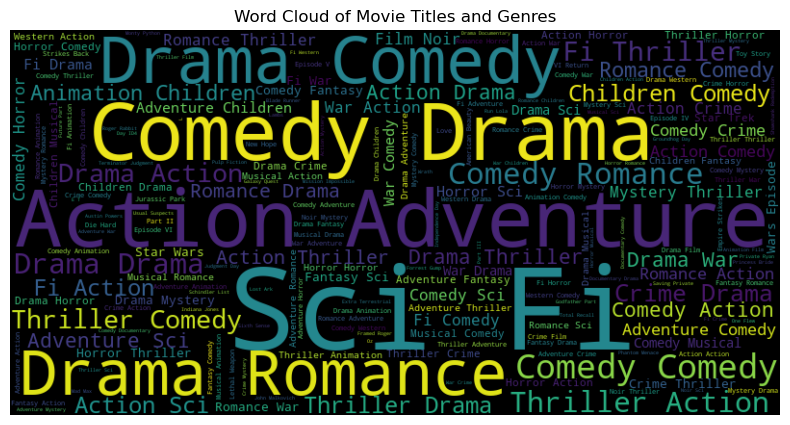

In [22]:
# Assuming df_cleaned is your DataFrame with 'Title' and 'Genres' columns

# Convert all elements in 'Genres' to strings if they are lists
def convert_genres(genres):
    if isinstance(genres, list):
        return ' '.join(genres)
    return str(genres)

df_cleaned['Genres'] = df_cleaned['Genres'].apply(convert_genres)

# Combine all movie titles and genres into a single string
all_titles = ' '.join(df_cleaned['Title'].astype(str))
all_genres = ' '.join(df_cleaned['Genres'])

# Combine titles and genres
combined_text = all_titles + ' ' + all_genres

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(combined_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Movie Titles and Genres')
plt.show()

The word cloud visualizes the frequency of movie genres and titles, with larger words indicating more common occurrences:

	•	Comedy, Drama, Action, Adventure, and Sci-Fi are prominently displayed, showing that these genres are the most frequent in the dataset.
	•	Other genres like Thriller, Romance, and Children’s also appear frequently but in smaller font sizes, indicating moderate representation.
	•	Niche genres such as Western, Film Noir, and Musical are smaller, highlighting their relative rarity.
	•	The word cloud effectively represents the distribution of popular genres, with a clear dominance of the most common categories such as Comedy and Drama.

# Task 1: kNN-based Collaborative Filtering


In [104]:
from sklearn.impute import KNNImputer
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from surprise import accuracy

# Prepare the data without filling missing ratings with 0
user_movie_ratings = df_cleaned.pivot(index='UserID', columns='Title', values='Rating')

# Step 1: Apply KNN Imputer to fill missing values
imputer = KNNImputer(n_neighbors=5, metric='nan_euclidean')
user_movie_ratings_filled = pd.DataFrame(imputer.fit_transform(user_movie_ratings),
                                         index=user_movie_ratings.index,
                                         columns=user_movie_ratings.columns)



# Now, use the filled ratings for your KNN-based prediction

def apply_floor_rounding(rating):
    """Take the integer part of the rating."""
    return np.floor(rating)

def predict_ratings(user_movie_ratings, user_index, k, metric):
    model_knn = NearestNeighbors(metric=metric, algorithm='auto')
    
    # Step 2: Fit the KNN model using the dataframe after KNN imputation
    model_knn.fit(user_movie_ratings_filled)
    
    # Find the k nearest neighbors
    distances, indices = model_knn.kneighbors(user_movie_ratings_filled.iloc[[user_index]], n_neighbors=k+1)
    similarities = 1 - distances.flatten()

    # Get the neighbor's ratings (valid ones)
    user_ratings = user_movie_ratings_filled.iloc[indices.flatten()[1:], :].copy()
    
    # Apply similarity-based weighted sum
    weighted_sum = np.nansum(similarities[1:, None] * user_ratings, axis=0)
    sum_of_weights = np.nansum(similarities[1:, None] * user_ratings.notna(), axis=0)

    # Predict ratings by dividing the weighted sum by the sum of weights
    with np.errstate(divide='ignore', invalid='ignore'):
        predicted_ratings = np.divide(weighted_sum, sum_of_weights, where=sum_of_weights != 0)
    predicted_ratings[sum_of_weights == 0] = np.nan

    # Apply floor rounding (take the integer part)
    final_predictions = pd.Series(predicted_ratings, index=user_movie_ratings.columns)
    final_predictions = final_predictions.apply(apply_floor_rounding)

    return final_predictions

# Randomly choose one user as the test set with random state 42
np.random.seed(42)
test_user_index = np.random.choice(user_movie_ratings.index)
true_ratings = user_movie_ratings.loc[test_user_index, :]

# Evaluate the impact of different k values and similarity metrics
k_values = [5, 10, 15, 20, 25]
similarity_metrics = ['cosine', 'euclidean']
results = {}

# Loop through all k values and similarity metrics and ensure everything is printed
for metric in similarity_metrics:
    for k in k_values:
        predicted_ratings = predict_ratings(user_movie_ratings, test_user_index, k, metric)

        # Filter out movies the user hasn't rated (apply the same mask to true and predicted ratings)
        mask = true_ratings.notna()  # Mask to filter movies the user has rated
        true_ratings_filtered = true_ratings[mask].values
        predicted_ratings_filtered = predicted_ratings.reindex(true_ratings.index)[mask]  # Align indices and apply mask

        # Inspect the true and predicted ratings for this user
        print(f"\nInspecting predictions for Metric: {metric}, k: {k}")
        print("True ratings (first 10):", true_ratings_filtered[:10])
        print("Predicted ratings (first 10):", predicted_ratings_filtered[:10])

        # Calculate RMSE
        rmse = accuracy.rmse(true_ratings_filtered, predicted_ratings_filtered)
        results[(metric, k)] = rmse
        print(f"Metric: {metric}, k: {k}, RMSE: {rmse}")

# Output the full results for all k values and metrics
print("\nFinal RMSE Results:")
for (metric, k), rmse in results.items():
    print(f"Metric: {metric}, k: {k}, RMSE: {rmse}")

# Find the optimal k and similarity metric
optimal_metric, optimal_k = min(results, key=results.get)
print(f"\nOptimal Metric: {optimal_metric}, Optimal k: {optimal_k}, RMSE: {results[(optimal_metric, optimal_k)]}")


KeyError: 'Title'

# Task 2: Matrix Factorization-based Recommendation

In [1]:
def feature_selection(df):
    keep_cols = ['UserID','MovieID','Rating']
    for i in df.columns:
        if i not in keep_cols:
            df.drop(i, inplace = True, axis = 1)
    return df

In [2]:
# !pip install scikit-surprise

In [23]:
# Import necessary libraries
import pandas as pd
import numpy as np
from surprise import Reader, Dataset, SVD
from surprise.model_selection import train_test_split


In [109]:
df_selected = pd.read_csv('./cleaned_data.csv')

In [110]:
df_selected.columns

Index(['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code', 'MovieID',
       'Rating', 'Timestamp', 'Title', 'Genres', 'Action', 'Adventure',
       'Animation', 'Children's', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western'],
      dtype='object')

In [111]:
# Calculate global mean
global_mean = round(df_selected['Rating'].mean())

# Fill missing ratings with the mean rating for each user
df_selected['Rating'] = df_selected.groupby('UserID')['Rating'].transform(lambda x: x.fillna(round(x.mean())))

# For users who have no ratings, fall back to global mean
df_selected['Rating'].fillna(global_mean, inplace=True)

df_filled = df_selected.copy()

The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




In [27]:
df_filled.to_csv('filled_data.csv', index=False)

In [28]:
df_filled.columns

Index(['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code', 'MovieID',
       'Rating', 'Timestamp', 'Title', 'Genres', 'Action', 'Adventure',
       'Animation', 'Children's', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western'],
      dtype='object')

In [112]:
# Step 1: Randomly select 5 unique movies for the test set
test_movies = df_filled['MovieID'].sample(5, random_state=42).unique()

# Step 2: Create the test set and training set
test_df = df_filled[df_filled['MovieID'].isin(test_movies)]   # Test set with selected 5 movies
train_df = df_filled[~df_filled['MovieID'].isin(test_movies)]  # Training set without the selected movies

In [30]:
train_df 

,UserID,Gender,Age,Occupation,Zip-code,MovieID,Rating,Timestamp,Title,Genres,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,F,1,10,48067,1193,5.0,978300760,One Flew Over the Cuckoo's Nest (1975),['Drama'],...,0,0,0,0,0,0,0,0,0,0
1,1,F,1,10,48067,661,3.0,978302109,James and the Giant Peach (1996),"['Animation', ""Children's"", 'Musical']",...,0,0,0,1,0,0,0,0,0,0
2,1,F,1,10,48067,914,3.0,978301968,My Fair Lady (1964),"['Musical', 'Romance']",...,0,0,0,1,0,1,0,0,0,0
3,1,F,1,10,48067,3408,4.0,978300275,Erin Brockovich (2000),['Drama'],...,0,0,0,0,0,0,0,0,0,0
4,1,F,1,10,48067,2355,5.0,978824291,"Bug's Life, A (1998)","['Animation', ""Children's"", 'Comedy']",...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998534,6040,M,25,6,11106,1091,1.0,956716541,Weekend at Bernie's (1989),['Comedy'],...,0,0,0,0,0,0,0,0,0,0
998535,6040,M,25,6,11106,1094,5.0,956704887,"Crying Game, The (1992)","['Drama', 'Romance', 'War']",...,0,0,0,0,0,1,0,0,1,0
998536,6040,M,25,6,11106,562,5.0,956704746,Welcome to the Dollhouse (1995),"['Comedy', 'Drama']",...,0,0,0,0,0,0,0,0,0,0
998537,6040,M,25,6,11106,1096,4.0,956715648,Sophie's Choice (1982),['Drama'],...,0,0,0,0,0,0,0,0,0,0


In [67]:
# Step 3: Prepare the dataset for surprise
# Use Reader to define the rating scale (in this case, 0-5)
reader = Reader(rating_scale=(0, 5))

# Load the training data for surprise
train_data = Dataset.load_from_df(train_df[['UserID', 'MovieID', 'Rating']], reader)

# Build the full trainset from the training data
trainset = train_data.build_full_trainset()

# Step 4: Train the SVD algorithm
algo = SVD()
algo.fit(trainset)

# Step 5: Predict ratings for the test set
predictions = []

for index, row in test_df.iterrows():
    user_id = row['UserID']
    movie_id = row['MovieID']
    true_rating = row['Rating']
    
    # Predict the rating for the user-movie pair
    pred = algo.predict(user_id, movie_id, r_ui=true_rating)
    predictions.append(pred)

In [68]:
# Step 6: Evaluate the model using RMSE
from surprise import accuracy
rmse_baseline = accuracy.rmse(predictions)
print(f"RMSE: {rmse_baseline:.4f}")

RMSE: 0.9861
RMSE: 0.9861


In [69]:
# Step 5: Hyperparameter tuning using RandomizedSearchCV
from surprise.model_selection import RandomizedSearchCV
param_dist = {
    'n_factors': [10, 20, 50, 100],         # Number of latent factors
    'n_epochs': [10, 20, 30, 40],           # Number of training epochs
    'lr_all': [0.002, 0.005, 0.01, 0.02],   # Learning rate for SGD
    'reg_all': [0.02, 0.05, 0.1, 0.2]       # Regularization term
}

# Perform random search with 10 iterations
# rs = RandomizedSearchCV(SVD, param_dist, measures=['rmse'], cv=3, n_iter=10, random_state=42)
# rs.fit(train_data)

# # Step 6: Best model from RandomizedSearchCV
# best_params = rs.best_params['rmse']
# print(f"Best Parameters from Randomized Search: {best_params}")


In [70]:
# Step 6: Best model from RandomizedSearchCV
best_params = {'n_factors': 20, 'n_epochs': 40, 'lr_all': 0.01, 'reg_all': 0.02}
print(f"Best Parameters from Randomized Search: {best_params}")

Best Parameters from Randomized Search: {'n_factors': 20, 'n_epochs': 40, 'lr_all': 0.01, 'reg_all': 0.02}


In [71]:
best_params

{'n_factors': 20, 'n_epochs': 40, 'lr_all': 0.01, 'reg_all': 0.02}

In [72]:
# Train SVD with the best parameters
algo_tuned = SVD(n_factors=best_params['n_factors'], n_epochs=best_params['n_epochs'],
                 lr_all=best_params['lr_all'], reg_all=best_params['reg_all'])
algo_tuned.fit(trainset)

# Predict ratings for the test set using the tuned model
predictions_tuned = []
for index, row in test_df.iterrows():
    user_id = row['UserID']
    movie_id = row['MovieID']
    true_rating = row['Rating']
    pred = algo_tuned.predict(user_id, movie_id, r_ui=true_rating)
    predictions_tuned.append(pred)

# Evaluate the tuned SVD model
rmse_tuned = accuracy.rmse(predictions_tuned)
print(f"Tuned RMSE: {rmse_tuned:.4f}")

# Step 7: Compare baseline and tuned RMSE
print(f"Improvement: {rmse_baseline - rmse_tuned:.4f} RMSE reduction")

RMSE: 0.9902
Tuned RMSE: 0.9902
Improvement: -0.0041 RMSE reduction


## Hybrid Approach with SVD and DNN

In [113]:
!pip install catboost

In [118]:
train_cols = ['Action','Age','Occupation', 'Adventure',
       'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western','Gender_F', 'Gender_M']

In [115]:
train_df = pd.get_dummies(train_df, columns=['Gender'])


In [116]:
test_df = pd.get_dummies(test_df, columns=['Gender'])

In [117]:
train_df.columns

Index(['UserID', 'Age', 'Occupation', 'Zip-code', 'MovieID', 'Rating',
       'Timestamp', 'Title', 'Genres', 'Action', 'Adventure', 'Animation',
       'Children's', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
       'Thriller', 'War', 'Western', 'Gender_F', 'Gender_M'],
      dtype='object')

In [119]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD
from catboost import CatBoostRegressor

# Step 1: Load and prepare the Surprise dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_filled[['UserID', 'MovieID', 'Rating']], reader)
trainset = data.build_full_trainset()

# Step 2: Train SVD model
svd_model = SVD()
svd_model.fit(trainset)

# Step 3: Extract latent features for users and items
train_df['user_latent'] = train_df['UserID'].apply(lambda x: svd_model.pu[trainset.to_inner_uid(x)])
train_df['item_latent'] = train_df['MovieID'].apply(lambda x: svd_model.qi[trainset.to_inner_iid(x)])

# Reset index and rename latent columns to avoid duplicates
train_df.reset_index(drop=True, inplace=True)

# Convert latent features to DataFrames with custom column names to avoid conflicts
user_latent_df = pd.DataFrame(train_df['user_latent'].to_list(), columns=[f'user_latent_{i}' for i in range(len(train_df['user_latent'][0]))])
item_latent_df = pd.DataFrame(train_df['item_latent'].to_list(), columns=[f'item_latent_{i}' for i in range(len(train_df['item_latent'][0]))])

# Step 4: Prepare CatBoost data
# Concatenate the latent factors with other metadata (e.g., Gender, Age, Occupation, Genres)
X_train = pd.concat([user_latent_df, item_latent_df,
                     train_df[train_cols].reset_index(drop=True)], axis=1)


# Ensure no NaN values in the data
X_train.fillna(0, inplace=True)

In [120]:
# Ensure unique column names
X_train.columns = [f'feature_{i}' if col == '' else col for i, col in enumerate(X_train.columns)]
X_train = X_train.astype(float)
y_train = train_df['Rating']

In [121]:
# Step 5: Train CatBoost model
catboost_model = CatBoostRegressor(iterations=20000, learning_rate=0.01, depth=6, task_type = 'GPU')
catboost_model.fit(X_train, y_train)  # categorical features

0:	learn: 1.1152200	total: 39.7ms	remaining: 6m 36s
1:	learn: 1.1140308	total: 60ms	remaining: 4m 59s
2:	learn: 1.1128618	total: 80ms	remaining: 4m 26s
3:	learn: 1.1117155	total: 100ms	remaining: 4m 10s
4:	learn: 1.1105879	total: 120ms	remaining: 4m
5:	learn: 1.1094949	total: 140ms	remaining: 3m 53s
6:	learn: 1.1084046	total: 159ms	remaining: 3m 47s
7:	learn: 1.1073334	total: 179ms	remaining: 3m 43s
8:	learn: 1.1062897	total: 198ms	remaining: 3m 39s
9:	learn: 1.1052485	total: 218ms	remaining: 3m 37s
10:	learn: 1.1042364	total: 236ms	remaining: 3m 34s
11:	learn: 1.1032213	total: 254ms	remaining: 3m 31s
12:	learn: 1.1022227	total: 273ms	remaining: 3m 29s
13:	learn: 1.1012479	total: 292ms	remaining: 3m 28s
14:	learn: 1.1002673	total: 312ms	remaining: 3m 27s
15:	learn: 1.0993049	total: 331ms	remaining: 3m 26s
16:	learn: 1.0983550	total: 349ms	remaining: 3m 25s
17:	learn: 1.0974340	total: 368ms	remaining: 3m 23s
18:	learn: 1.0965300	total: 386ms	remaining: 3m 22s
19:	learn: 1.0956210	total:

In [122]:
# Step 6: Extract latent features for test data using SVD
# Handle unseen items by assigning a default value if an item was not part of the trainset
def get_item_latent_factors(item_id):
    try:
        return svd_model.qi[trainset.to_inner_iid(item_id)]
    except ValueError:
        # Return a vector of zeros or an average latent factor for unseen items
        return np.zeros(svd_model.qi.shape[1])  # shape[1] returns the number of latent factors

# Extract latent features for test data using SVD
test_df['user_latent'] = test_df['UserID'].apply(lambda x: svd_model.pu[trainset.to_inner_uid(x)])
test_df['item_latent'] = test_df['MovieID'].apply(get_item_latent_factors)

# Reset index and rename latent columns for test data
test_df.reset_index(drop=True, inplace=True)

# Prepare the test set for CatBoost
user_latent_test_df = pd.DataFrame(test_df['user_latent'].to_list(), columns=[f'user_latent_{i}' for i in range(len(test_df['user_latent'][0]))])
item_latent_test_df = pd.DataFrame(test_df['item_latent'].to_list(), columns=[f'item_latent_{i}' for i in range(len(test_df['item_latent'][0]))])

X_test = pd.concat([user_latent_test_df, item_latent_test_df,
                    test_df[train_cols].reset_index(drop=True)], axis=1)

# Ensure no NaN values in the test data
X_test.fillna(0, inplace=True)

# Ensure unique column names for test set
X_test.columns = [f'feature_{i}' if col == '' else col for i, col in enumerate(X_test.columns)]

# Step 8: Predict ratings
predictions = np.round(catboost_model.predict(X_test)).astype(int)

In [123]:
from sklearn.metrics import mean_squared_error

# Step 9: Calculate RMSE
true_ratings = test_df['Rating']  # The actual ratings in the test set
predicted_ratings = predictions  # The predicted ratings from CatBoost

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(true_ratings, predicted_ratings))

print(f"RMSE: {rmse}")

RMSE: 0.7666853946483724


# Task 3: Ranking-based Evaluation and Comparison

In [1]:
def feature_selection(df):
    keep_cols = ['UserID','MovieID','Title','Rating']
    for i in df.columns:
        if i not in keep_cols:
            df.drop(i, inplace = True, axis = 1)
    return df

In [7]:
import pandas as pd
from surprise import Dataset, Reader, KNNBasic
import numpy as np

In [20]:
df_filled = pd.read_csv('filled_data.csv')

/tmp/ipykernel_1663220/3731361191.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_filled = pd.read_csv('filled_data.csv')


In [8]:
df_filled = pd.read_csv('filled_data.csv')
df_filled_selected = feature_selection(df_filled)

/tmp/ipykernel_1663220/3661960812.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_filled = pd.read_csv('filled_data.csv')


In [ ]:
import pandas as pd
from surprise import Dataset, Reader, KNNBasic
import numpy as np

# Define a Reader object for Surprise
reader = Reader(rating_scale=(1, 5))

# Convert the data to the Surprise format
data = Dataset.load_from_df(df_filled_selected[['UserID', 'MovieID','Rating']], reader)

# Get users who have rated more than 100 movies
user_ratings_count = df_filled_selected.groupby('UserID')['MovieID'].count()
eligible_users = user_ratings_count[user_ratings_count > 100].index

# Randomly select 10 users from eligible users as the test set
random_users = np.random.choice(eligible_users, size=10, replace=False)

# Split the data into training and test sets manually
trainset_df = df_filled_selected[~df_filled_selected['UserID'].isin(random_users)]  # Exclude test users from training set
testset_df = df_filled_selected[df_filled_selected['UserID'].isin(random_users)]  # Include only the test users

# Create a lookup dictionary for MovieID -> MovieTitle
movie_id_to_title = df_filled_selected[['MovieID', 'Title']].drop_duplicates().set_index('MovieID')['Title'].to_dict()

# Convert the training data into the Surprise format
train_data = Dataset.load_from_df(trainset_df[['UserID', 'MovieID', 'Rating']], reader)
trainset = train_data.build_full_trainset()

# Train a KNN-based collaborative filtering model
sim_options = {'name': 'cosine', 'user_based': True}
model = KNNBasic(sim_options=sim_options)
model.fit(trainset)

# Prepare the testset in Surprise format: list of (user_id, movie_id, actual_rating) for all users in testset
testset = [tuple(x) for x in testset_df[['UserID', 'MovieID', 'Rating']].values]

# Predict ratings for the test set users (test predictions)
test_predictions = model.test(testset)

# Use the lookup dictionary to add movie titles to the predictions
predictions_list = []
for uid, iid, true_r, est, _ in test_predictions:
    movie_title = movie_id_to_title.get(iid, "Unknown Title")
    predictions_list.append({'UserID': uid, 'MovieID': iid, 'Title': movie_title, 'TrueRating': true_r, 'EstimatedRating': est})

# Convert the list to a DataFrame and save to a CSV file for later evaluation
predictions_df = pd.DataFrame(predictions_list)
predictions_df.to_csv('saved_test_predictions_with_titles.csv', index=False)

print("Test predictions saved to 'saved_test_predictions_with_titles.csv'")

# Function to get top-n recommendations for selected users based on the test predictions
def get_top_n_recommendations(predictions, n=20):
    # Map the predictions to each user
    top_n = {}
    for uid, iid, true_r, est, _ in predictions:
        movie_title = movie_id_to_title.get(iid, "Unknown Title")
        if uid not in top_n:
            top_n[uid] = []
        top_n[uid].append((iid, movie_title, est))

    # For each user, sort the predictions by the estimated rating
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[2], reverse=True)
        top_n[uid] = [(iid, movie_title) for (iid, movie_title, _) in user_ratings[:n]]
    
    return top_n

# Get top-20 recommendations for the test set users
top_20_recommendations = get_top_n_recommendations(test_predictions, n=20)

# Display recommendations for each test user
for user, movies in top_20_recommendations.items():
    print(f"Top 20 recommendations for User {user}:")
    for movie_id, movie_title in movies:
        print(f"MovieID: {movie_id}, MovieTitle: {movie_title}")


In [6]:
df_result = pd.read_csv('saved_test_predictions_with_titles.csv')
df_result.head()


NameError: name 'pd' is not defined

## SVD + Catboost Hybrid recommender system

In [9]:
train_cols = ['Action','Age','Occupation', 'Adventure',
       'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western','Gender_F', 'Gender_M']

In [23]:
df_filled  = pd.get_dummies(df_filled,  columns=['Gender'])

In [12]:
train_df.columns

Index(['UserID', 'MovieID', 'Rating', 'Gender_$1,000,000 Duck (1971)',
       'Gender_'Night Mother (1986)', 'Gender_'Til There Was You (1997)',
       'Gender_'burbs, The (1989)', 'Gender_...And Justice for All (1979)',
       'Gender_10 Things I Hate About You (1999)',
       'Gender_101 Dalmatians (1961)',
       ...
       'Gender_Young Poisoner's Handbook, The (1995)',
       'Gender_Young Sherlock Holmes (1985)',
       'Gender_Young and Innocent (1937)',
       'Gender_Your Friends and Neighbors (1998)',
       'Gender_Zed & Two Noughts, A (1985)', 'Gender_Zero Effect (1998)',
       'Gender_Zeus and Roxanne (1997)', 'Gender_eXistenZ (1999)',
       'user_latent', 'item_latent'],
      dtype='object', length=3265)

In [24]:
# Step 4: Filter users who have rated more than 100 movies
user_ratings_count = df_filled.groupby('UserID')['MovieID'].count()
eligible_users = user_ratings_count[user_ratings_count > 100].index

# Step 5: Randomly select 10 users from eligible users as the test set
random_users = np.random.choice(eligible_users, size=10, replace=False)

# Step 6: Split the data into training and test sets manually
train_df = df_filled[~df_filled['UserID'].isin(random_users)]  # Exclude test users from training set
test_df = df_filled[df_filled['UserID'].isin(random_users)]  # Include only the test users

In [35]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, ndcg_score, average_precision_score

# Assuming df_filled is your dataset and contains the columns ['UserID', 'MovieID', 'Rating', 'Gender', 'Age', 'Occupation', 'Genres']

# Step 1: Load and prepare the Surprise dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_filled[['UserID', 'MovieID', 'Rating']], reader)
trainset = data.build_full_trainset()

# Step 2: Train SVD model
svd_model = SVD()
svd_model.fit(trainset)

# Step 3: Extract latent features for users and items
train_df['user_latent'] = train_df['UserID'].apply(lambda x: svd_model.pu[trainset.to_inner_uid(x)])
train_df['item_latent'] = train_df['MovieID'].apply(lambda x: svd_model.qi[trainset.to_inner_iid(x)])

# Reset index and rename latent columns to avoid duplicates
train_df.reset_index(drop=True, inplace=True)

# Convert latent features to DataFrames with custom column names to avoid conflicts
user_latent_df = pd.DataFrame(train_df['user_latent'].to_list(), columns=[f'user_latent_{i}' for i in range(len(train_df['user_latent'][0]))])
item_latent_df = pd.DataFrame(train_df['item_latent'].to_list(), columns=[f'item_latent_{i}' for i in range(len(train_df['item_latent'][0]))])

# Step 7: Prepare CatBoost data
X_train = pd.concat([user_latent_df, item_latent_df, train_df[train_cols].reset_index(drop=True)], axis=1)

# Ensure no NaN values in the data
X_train.fillna(0, inplace=True)
X_train = X_train.astype(float)
y_train = train_df['Rating']

# Step 8: Train CatBoost model
catboost_model = CatBoostRegressor(iterations=25000, learning_rate=0.01, depth=6, verbose=False, task_type='GPU')
catboost_model.fit(X_train, y_train)

# Step 9: Handle unseen items by assigning a default value for latent factors
def get_item_latent_factors(item_id):
    try:
        return svd_model.qi[trainset.to_inner_iid(item_id)]
    except ValueError:
        # Return a vector of zeros for unseen items
        return np.zeros(svd_model.qi.shape[1])

# Extract latent features for test data using SVD
test_df['user_latent'] = test_df['UserID'].apply(lambda x: svd_model.pu[trainset.to_inner_uid(x)])
test_df['item_latent'] = test_df['MovieID'].apply(get_item_latent_factors)

# Reset index and rename latent columns for test data
test_df.reset_index(drop=True, inplace=True)

# Prepare the test set for CatBoost
user_latent_test_df = pd.DataFrame(test_df['user_latent'].to_list(), columns=[f'user_latent_{i}' for i in range(len(test_df['user_latent'][0]))])
item_latent_test_df = pd.DataFrame(test_df['item_latent'].to_list(), columns=[f'item_latent_{i}' for i in range(len(test_df['item_latent'][0]))])

X_test = pd.concat([user_latent_test_df, item_latent_test_df, test_df[train_cols].reset_index(drop=True)], axis=1)

# Ensure no NaN values in the test data
X_test.fillna(0, inplace=True)

# Step 10: Predict ratings with CatBoost
predictions = np.round(catboost_model.predict(X_test)).astype(int)

# Step 11: Calculate RMSE
true_ratings = test_df['Rating']  # The actual ratings in the test set
predicted_ratings = predictions  # The predicted ratings from CatBoost

rmse = np.sqrt(mean_squared_error(true_ratings, predicted_ratings))
print(f"RMSE: {rmse}")

# Step 12: Compute NDCG and AP for each user using sklearn

/tmp/ipykernel_1663220/2271492075.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['user_latent'] = train_df['UserID'].apply(lambda x: svd_model.pu[trainset.to_inner_uid(x)])
/tmp/ipykernel_1663220/2271492075.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['item_latent'] = train_df['MovieID'].apply(lambda x: svd_model.qi[trainset.to_inner_iid(x)])


RMSE: 0.773176041417173
   UserID   NDCG@10     AP@10
0     224  0.877434  0.717482
1     828  0.885493  0.782798
2    1058  1.000000  0.850462
3    2567  1.000000  0.712012
4    2894  0.967761  0.912179
5    2944  0.998199  0.958366
6    2980  0.762485  0.734821
7    3532  0.954545  0.889739
8    4058  1.000000  0.839065
9    4361  1.000000  0.888159


/tmp/ipykernel_1663220/2271492075.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['user_latent'] = test_df['UserID'].apply(lambda x: svd_model.pu[trainset.to_inner_uid(x)])
/tmp/ipykernel_1663220/2271492075.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['item_latent'] = test_df['MovieID'].apply(get_item_latent_factors)


In [39]:
results = []
k = 20  # Setting k for NDCG@k and AP@k

for user_id, user_df in test_df.groupby('UserID'):
    # Sort by predicted ratings
    user_df['PredictedRating'] = predictions[test_df['UserID'] == user_id]
    user_df_sorted = user_df.sort_values(by='PredictedRating', ascending=False)

    # Binary relevance for NDCG and AP calculation (relevance: 1 if TrueRating >= 4, else 0)
    relevance = [1 if rating >= 4 else 0 for rating in user_df_sorted['Rating']]

    # Use sklearn's ndcg_score and average_precision_score
    true_relevance = np.asarray(relevance).reshape(1, -1)
    predicted_scores = np.asarray(user_df_sorted['PredictedRating']).reshape(1, -1)

    ndcg = ndcg_score(true_relevance, predicted_scores,k=k) 
    ap = average_precision_score(true_relevance.flatten(), predicted_scores.flatten())

    # Store results
    results.append({'UserID': user_id, 'NDCG@20': ndcg, 'AP@20': ap})

# Convert results to DataFrame and display/save
results_df = pd.DataFrame(results)
print(results_df)

   UserID   NDCG@20     AP@20
0     224  0.877434  0.717482
1     828  0.885493  0.782798
2    1058  1.000000  0.850462
3    2567  1.000000  0.712012
4    2894  0.967761  0.912179
5    2944  0.998199  0.958366
6    2980  0.762485  0.734821
7    3532  0.954545  0.889739
8    4058  1.000000  0.839065
9    4361  1.000000  0.888159


In [42]:
average_ndcg_svd_catboost = results_df['NDCG@20'].mean()
average_ap_svd_catboost = results_df['AP@20'].mean()

# Print the averages
print(f"Average NDCG@20: {average_ndcg_svd_catboost}")
print(f"Average AP@20: {average_ap_svd_catboost}")

Average NDCG@20: 0.944591830890675
Average AP@20: 0.828508232174823


In [34]:

# Step 13: Get top-N recommendations for selected users
def get_top_n_recommendations(predictions, n=20):
    top_n = {}
    for uid, movie_id, rating in zip(test_df['UserID'], test_df['MovieID'], predictions):
        if uid not in top_n:
            top_n[uid] = []
        movie_title = movie_id_to_title.get(movie_id, "Unknown Title")
        top_n[uid].append((movie_id, movie_title, rating))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[2], reverse=True)
        top_n[uid] = [(movie_id, movie_title) for (movie_id, movie_title, _) in user_ratings[:n]]
    
    return top_n

# Create a movie title lookup dictionary
movie_id_to_title = df_filled[['MovieID', 'Title']].drop_duplicates().set_index('MovieID')['Title'].to_dict()

# Get top 20 recommendations for the test set users
top_20_recommendations = get_top_n_recommendations(predictions, n=20)

recommendations_list = []
# Collecting recommendations for each user
for user, movies in top_20_recommendations.items():
    print(f"Top 20 recommendations for User {user}:")
    for movie_id, movie_title in movies:
        print(f"MovieID: {movie_id}, MovieTitle: {movie_title}")
        # Append the UserID, MovieID, and MovieTitle to the list
        recommendations_list.append({'UserID': user, 'MovieID': movie_id, 'MovieTitle': movie_title})

# Convert the list of recommendations to a DataFrame
recommendations_df = pd.DataFrame(recommendations_list)

# Save the DataFrame to a CSV file
recommendations_df.to_csv('top_20_recommendations_svd_catboost.csv', index=False)

Top 20 recommendations for User 224:
MovieID: 3793, MovieTitle: X-Men (2000)
MovieID: 1259, MovieTitle: Stand by Me (1986)
MovieID: 1, MovieTitle: Toy Story (1995)
MovieID: 1196, MovieTitle: Star Wars: Episode V - The Empire Strikes Back (1980)
MovieID: 1197, MovieTitle: Princess Bride, The (1987)
MovieID: 2081, MovieTitle: Little Mermaid, The (1989)
MovieID: 1356, MovieTitle: Star Trek: First Contact (1996)
MovieID: 1500, MovieTitle: Grosse Pointe Blank (1997)
MovieID: 2248, MovieTitle: Say Anything... (1989)
MovieID: 2336, MovieTitle: Elizabeth (1998)
MovieID: 3148, MovieTitle: Cider House Rules, The (1999)
MovieID: 2355, MovieTitle: Bug's Life, A (1998)
MovieID: 1704, MovieTitle: Good Will Hunting (1997)
MovieID: 3317, MovieTitle: Wonder Boys (2000)
MovieID: 1641, MovieTitle: Full Monty, The (1997)
MovieID: 104, MovieTitle: Happy Gilmore (1996)
MovieID: 110, MovieTitle: Braveheart (1995)
MovieID: 2396, MovieTitle: Shakespeare in Love (1998)
MovieID: 2542, MovieTitle: Lock, Stock & T